In [1]:
from datasets import load_dataset

datasets = load_dataset('code_x_glue_cc_code_to_code_trans')

In [2]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 10300
    })
    validation: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 1000
    })
})

In [3]:
max([len(s) for s in datasets['train']['java']])

1398

In [4]:
load = 'Salesforce/codet5p-220m'

max_source_len = 250
max_target_len = 250

SAVE_PATH = 'our_t5_code_trans_full_220m'

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(load,
                                          pad_token='<pad>',
                                          pad_token_id=-100)

In [6]:
def preprocess_function(examples):
    source = examples["java"]
    target = examples["cs"]

    model_inputs = tokenizer(source, max_length=max_source_len, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(target, max_length=max_target_len, padding="max_length", truncation=True, return_tensors="pt")

    model_inputs["labels"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels['input_ids']
    ]
    return model_inputs

tokenized_datasets = datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=datasets['train'].column_names,
    # num_proc=64,
    num_proc=4,
)

In [7]:
tokenized_datasets['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10300
})

In [8]:
print(tokenizer.pad_token_id)

0


In [9]:
from transformers import AutoConfig, AutoModelForSeq2SeqLM
import evaluate
import codebleu

load = 'our_t5_code_trans_full_220m/checkpoint-125000'

#config = AutoConfig.from_pretrained('google-t5/t5-base')
config = AutoConfig.from_pretrained(load)
config.decoder_start_token_id = tokenizer.bos_token_id
config.decoder_end_token_id = tokenizer.eos_token_id
config.pad_token_id = tokenizer.pad_token_id

model = AutoModelForSeq2SeqLM.from_config(config).to('cuda')

bleu_metric = evaluate.load("bleu")

# computes bleu and codebleu metric
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    labels = [
        [(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels
    ]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    print(decoded_labels, decoded_predictions)

    bleu = bleu_metric.compute(predictions=decoded_predictions, references=decoded_labels)
    codebleu_result = codebleu.calc_codebleu(predictions=decoded_predictions, references=decoded_labels, lang="c_sharp")
    
    return {
        **{ "bleu_" + key: val for key, val in bleu.items() },
        **{ "codebleu_" + key: val for key, val in codebleu_result.items() }
    }

2024-06-24 17:54:02.737051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 17:54:03.778674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
compute_metrics((tokenized_datasets['validation']['input_ids'], tokenized_datasets['validation']['labels']))

['public DVRecord(RecordInputStream in1){_option_flags = in1.ReadInt();_promptTitle = ReadUnicodeString(in1);_errorTitle = ReadUnicodeString(in1);_promptText = ReadUnicodeString(in1);_errorText = ReadUnicodeString(in1);int field_size_first_formula = in1.ReadUShort();_not_used_1 = in1.ReadShort();_formula1 = NPOI.SS.Formula.Formula.Read(field_size_first_formula, in1);int field_size_sec_formula = in1.ReadUShort();_not_used_2 = in1.ReadShort();_formula2 = NPOI.SS.Formula.Formula.Read(field_size_sec_formula, in1);_regions = new CellRangeAddressList(in1);}\n', 'public override string ToString(){return Pattern();}\n', 'public InsertInstanceRequest(): base("Ots", "2016-06-20", "InsertInstance", "ots", "openAPI"){Method = MethodType.POST;}\n', 'public virtual bool contains(object o){return indexOf(o)!= -1;}\n', 'public java.nio.ByteBuffer encode(string s){return encode(java.nio.CharBuffer.wrap(java.lang.CharSequenceProxy.Wrap(s)));}\n', 'public override bool RequiresCommitBody(){return false;}

{'bleu_bleu': 0.49608912085574547,
 'bleu_precisions': [0.820835407521383,
  0.6563411584942354,
  0.537611982746362,
  0.4532213429140166],
 'bleu_brevity_penalty': 0.824173126435393,
 'bleu_length_ratio': 0.8379598028062192,
 'bleu_translation_length': 22097,
 'bleu_reference_length': 26370,
 'codebleu_codebleu': 0.3687013130254727,
 'codebleu_ngram_match_score': 0.20252408051859871,
 'codebleu_weighted_ngram_match_score': 0.2082818978376918,
 'codebleu_syntax_match_score': 0.5212312854930304,
 'codebleu_dataflow_match_score': 0.5427679882525698}

In [11]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    SAVE_PATH,
    evaluation_strategy="steps",
    eval_steps=500,
    predict_with_generate=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=200,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='codebleu_codebleu',
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=50)]
)

/home/kingofdog/.local/share/mise/installs/python/3.10/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train(SAVE_PATH + "/checkpoint-125000")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Step,Training Loss,Validation Loss


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
trainer.evaluate(tokenized_datasets['validation'])

/home/kingofdog/.local/share/mise/installs/python/3.10/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['public DVRecord(RecordInputStream in1){_option_flags = in1.ReadInt();_promptTitle = ReadUnicodeString(in1);_errorTitle = ReadUnicodeString(in1);_promptText = ReadUnicodeString(in1);_errorText = ReadUnicodeString(in1);int field_size_first_formula = in1.ReadUShort();_not_used_1 = in1.ReadShort();_formula1 = NPOI.SS.Formula.Formula.Read(field_size_first_formula, in1);int field_size_sec_formula = in1.ReadUShort();_not_used_2 = in1.ReadShort();_formula2 = NPOI.SS.Formula.Formula.Read(field_size_sec_formula, in1);_regions = new CellRangeAddressList(in1);}\n', 'public override string ToString(){return Pattern();}\n', 'public InsertInstanceRequest(): base("Ots", "2016-06-20", "InsertInstance", "ots", "openAPI"){Method = MethodType.POST;}\n', 'public virtual bool contains(object o){return indexOf(o)!= -1;}\n', 'public java.nio.ByteBuffer encode(string s){return encode(java.nio.CharBuffer.wrap(java.lang.CharSequenceProxy.Wrap(s)));}\n', 'public override bool RequiresCommitBody(){return false;}

Trainer is attempting to log a value of "[0.0, 0.0, 0.0, 0.0]" of type <class 'list'> for key "eval/bleu_precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 10.843831062316895,
 'eval_bleu_bleu': 0.0,
 'eval_bleu_precisions': [0.0, 0.0, 0.0, 0.0],
 'eval_bleu_brevity_penalty': 2.631071859640291e-05,
 'eval_bleu_length_ratio': 0.08661357603337126,
 'eval_bleu_translation_length': 2284,
 'eval_bleu_reference_length': 26370,
 'eval_codebleu_codebleu': 0.2501290655653072,
 'eval_codebleu_ngram_match_score': 0,
 'eval_codebleu_weighted_ngram_match_score': 0,
 'eval_codebleu_syntax_match_score': 0.0005162622612287042,
 'eval_codebleu_dataflow_match_score': 0.0,
 'eval_runtime': 29.1461,
 'eval_samples_per_second': 17.155,
 'eval_steps_per_second': 2.162}

In [14]:
eval_model = model.eval()

In [13]:
datasets['train'][42]

{'id': 42,
 'java': 'public static boolean equals(int[] array1, int[] array2) {if (array1 == array2) {return true;}if (array1 == null || array2 == null || array1.length != array2.length) {return false;}for (int i = 0; i < array1.length; i++) {if (array1[i] != array2[i]) {return false;}}return true;}\n',
 'cs': 'public static bool equals(int[] array1, int[] array2){if (array1 == array2){return true;}if (array1 == null || array2 == null || array1.Length != array2.Length){return false;}{for (int i = 0; i < array1.Length; i++){if (array1[i] != array2[i]){return false;}}}return true;}\n'}

In [16]:
tokenized_datasets['train'][42]

{'input_ids': [1,
  482,
  760,
  1250,
  1606,
  12,
  474,
  8526,
  526,
  21,
  16,
  509,
  8526,
  526,
  22,
  13,
  288,
  430,
  261,
  1126,
  21,
  422,
  526,
  22,
  13,
  288,
  2463,
  638,
  31,
  97,
  430,
  261,
  1126,
  21,
  422,
  446,
  747,
  526,
  22,
  422,
  446,
  747,
  526,
  21,
  18,
  2469,
  480,
  526,
  22,
  18,
  2469,
  13,
  288,
  2463,
  629,
  31,
  97,
  1884,
  261,
  474,
  277,
  273,
  374,
  31,
  277,
  411,
  526,
  21,
  18,
  2469,
  31,
  277,
  27245,
  288,
  430,
  261,
  1126,
  21,
  63,
  77,
  65,
  480,
  526,
  22,
  63,
  77,
  5717,
  288,
  2463,
  629,
  31,
  9090,
  2463,
  638,
  31,
  97,
  203,
  2,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [15]:
import torch

id = 1598

#print(datasets['train'][id])

example = tokenized_datasets['train'][id]
#print(example)

input_ids = torch.tensor([example['input_ids']]).cuda()
#print(tokenizer.decode(input_ids[0]))

output_ids = eval_model.generate(input_ids, max_length=5000)

compute_metrics((output_ids, [example['labels']]))

print("Java: ", datasets['train'][id]['java'])
print("  C#: ", tokenizer.decode(output_ids[0], skip_special_tokens=True))

['public virtual DescribeOrderableClusterOptionsResponse DescribeOrderableClusterOptions(DescribeOrderableClusterOptionsRequest request){var options = new InvokeOptions();options.RequestMarshaller = DescribeOrderableClusterOptionsRequestMarshaller.Instance;options.ResponseUnmarshaller = DescribeOrderableClusterOptionsResponseUnmarshaller.Instance;return Invoke<DescribeOrderableClusterOptionsResponse>(request, options);}\n'] ['FlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFlagFl

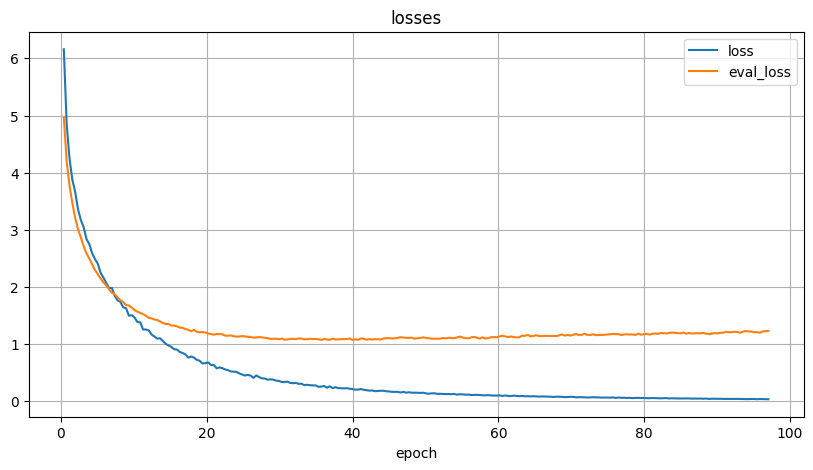

In [25]:
import matplotlib.pyplot as plt
import json

history = trainer.state.log_history
with open(SAVE_PATH + '/checkpoint-125000/trainer_state.json', 'r') as file:
    history = json.load(file)['log_history']
history = history

plt.figure(figsize=(10, 5))
plt.plot([data['epoch'] for data in history if 'loss' in data], [data['loss'] for data in history if 'loss' in data], label='loss')
plt.plot([data['epoch'] for data in history if 'eval_loss' in data], [data['eval_loss'] for data in history if 'eval_loss' in data], label='eval_loss')
plt.title('losses')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '/loss.pdf')

(-0.05, 1.05)

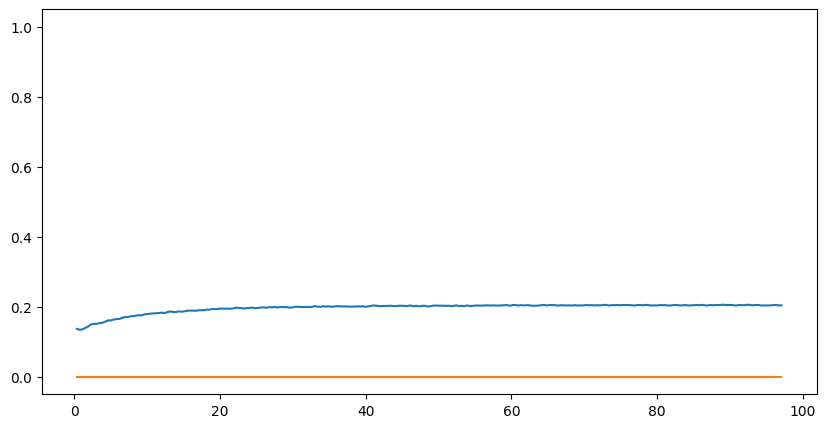

In [26]:
eval_history = [data for data in history if 'eval_loss' in data]

plt.figure(figsize=(10, 5))

plt.plot([data['epoch'] for data in eval_history], [data['eval_codebleu_codebleu'] for data in eval_history], label='CodeBLEU')
plt.plot([data['epoch'] for data in eval_history], [data['eval_bleu_bleu'] for data in eval_history], label='BLEU')

plt.ylim(-0.05, 1.05)